In [1]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute
    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax


In [2]:
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("Wholesale.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


In [3]:
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


By looking at the features of the data, we started segmenting our customers by common sense. For example, what type of businesses purchase large amount of milk and grocery (retailer)? What type of businesses purchase large amount of fresh, frozen and detergents paper (restaurant)? What type of businesses purchase large amount of delicassen (deli)? Let's do this!

In [4]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [5]:
data.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

### Selecting samples

To get a better understanding of the customers and how their data will transform through the analysis, we will select a few sample data points according to the above common sense segmentation and explore them in more detail. The selected samples should vary significantly from one another.

In [6]:
fresh_q1 = 3127.75
milk_q1 = 1533
grocery_q1 = 2153
frozen_q1 = 742.25
deter_q1 = 256.75
deli_q1 = 408.25

fresh_q3 = 16933.75
milk_q3 = 7190.25
grocery_q3 = 10655.75
frozen_q3 = 3554.25
deter_q3 = 3922
deli_q3 = 1820.25

### High milk, high grocery, low delicassen and low fresh.

In [7]:
data[(data.Grocery > grocery_q3) & (data.Milk > milk_q3) & (data.Delicassen < deli_q1) & (data.Fresh < fresh_q1)]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
43,630,11095,23998,787,9529,72
53,491,10473,11532,744,5611,224
81,219,9540,14403,283,7818,156
109,1406,16729,28986,673,836,3
159,355,7704,14682,398,8077,303
170,260,8675,13430,1116,7015,323


### High fresh, high frozen and low grocery.

In [8]:
data[(data.Fresh > fresh_q3) & (data.Frozen > frozen_q3) & (data.Grocery < grocery_q1)]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
39,56159,555,902,10002,212,2916
75,20398,1137,3,4407,3,975
126,19219,1840,1658,8195,349,483
190,16936,6250,1981,7332,118,64
237,18692,3838,593,4634,28,1215
258,56083,4563,2124,6422,730,3321
273,36817,3045,1493,4802,210,1824
283,25767,3613,2013,10303,314,1384
371,20105,1887,1939,8164,716,790
380,28257,944,2146,3881,600,270


### High delicassen, low frozen and low fresh

In [9]:
data[(data.Delicassen > deli_q3) & (data.Frozen < frozen_q1) & (data.Fresh < fresh_q1)]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
106,1454,6337,10704,133,6830,1831
155,1989,10690,19460,233,11577,2153
171,200,25862,19816,651,8773,6250
189,834,11577,11522,275,4027,1856
245,3062,6154,13916,230,8933,2784
304,161,7460,24773,617,11783,2410
315,1479,14982,11924,662,3891,3508
430,3097,4230,16483,575,241,2080


### Sample 1: High on milk and grocery, I guess it is a retailer. 
### Sample 2: High on fresh, frozen and detergents paper, I guess it is a restaurant.
### Sample 3: High on delicassen, I guess it is a deli.

In [10]:
indices = [109, 283, 315]

samples = pd.DataFrame(data.loc[indices], columns = data.columns).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1406,16729,28986,673,836,3
1,25767,3613,2013,10303,314,1384
2,1479,14982,11924,662,3891,3508


### Visualizing samples

In [11]:
data_mean = data.describe().loc['mean',:]
samples_bar = samples.append(data_mean)
samples_bar.index = indices + ['mean']

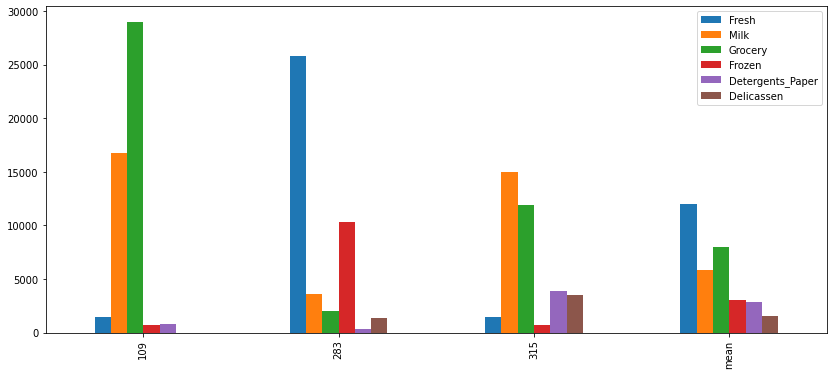

In [12]:
import seaborn as sns
samples_bar.plot(kind='bar', figsize=(14,6))

From this comparison plot, we can see that our three samples are very different with mean, and very different with each other.

Sample 1 represents a retailer, high purchase on grocery and milk; sample 2 represents a restaurant, high purchase on fresh and frozen; sample 3 represents a deli, high purchase on delicassen and detergents paper.

### Feature relevance

One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.
In the code block below, you will need to implement the following:
* Assign new_data a copy of the data by removing a feature of your choice using the DataFrame.drop function.
* Use sklearn.cross_validation.train_test_split to split the dataset into training and testing sets. Use the removed feature as your target label. Set a test_size of 0.25 and set a random_state.
* Import a decision tree regressor, set a random_state, and fit the learner to the training data.
* Report the prediction score of the testing set using the regressor's score function.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Create list to loop through
dep_vars = list(data.columns)


# Create loop to test each feature as a dependent variable
for var in dep_vars:

    # TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data.drop([var], axis = 1)
    # Confirm drop
    # display(new_data.head(2))

    # Create feature Series (Vector)
    new_feature = pd.DataFrame(data.loc[:, var])
    # Confirm creation of new feature
    # display(new_feature.head(2))

    # TODO: Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data, new_feature, test_size=0.25, random_state=42)

    # TODO: Create a decision tree regressor and fit it to the training set
    # Instantiate
    dtr = DecisionTreeRegressor(random_state=42)
    # Fit
    dtr.fit(X_train, y_train)

    # TODO: Report the score of the prediction using the testing set
    # Returns R^2
    score = dtr.score(X_test, y_test)
    print('R2 score for {} as dependent variable: {}'.format(var, score))

R2 score for Fresh as dependent variable: -0.3857497102040739
R2 score for Milk as dependent variable: 0.15627539501732113
R2 score for Grocery as dependent variable: 0.6818840085440834
R2 score for Frozen as dependent variable: -0.21013589012491396
R2 score for Detergents_Paper as dependent variable: 0.27166698062685013
R2 score for Delicassen as dependent variable: -2.254711537203931


### Question 2

Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?

Hint: The coefficient of determination, R^2, is scored between 0 and 1, with 1 being a perfect fit. A negative R^2 implies the model fails to fit the data.

### Answer:
I used a loop and predicted every single feature as a dependent variable with the results shown above.
As you can see, "Fresh", "Frozen" and "Delicassen" as dependent variables have negative R2 scores.
Their negative scores imply that they are necessary for identifying customers' spending habits because the remaining features cannot explain the variation in them.

Similarly, "Milk" and "Detergents_Paper" have very low R2 scores.
Their low scores also imply that they are necessary for identifying customers' spending habits.

However, "Grocery" has a R2 score of 0.68.
It is relative to the others it is much higher.
It may be not as necessary, compared to the other features, for identifying customers' spending habits.
We will explore this further.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

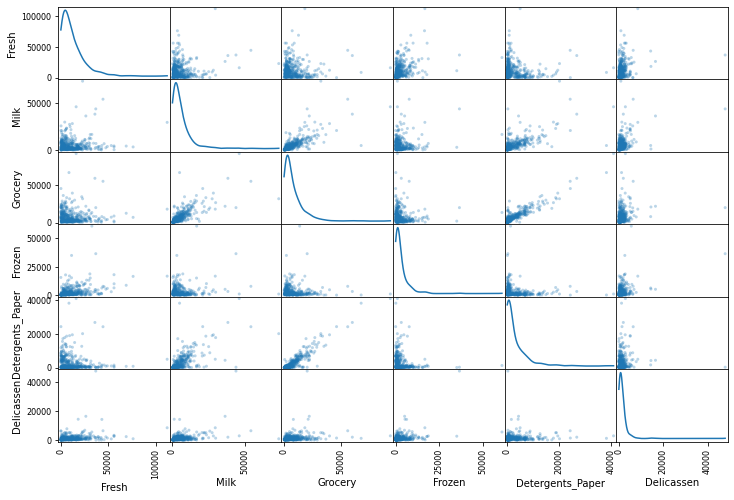

In [15]:
import pandas as pd
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (12,8), diagonal = 'kde');

### Correlation Matrix
* This is to cross-reference with the scatter matrix above to draw more accurate insights from the data.
* The higher the color is on the bar, the higher the correlation.

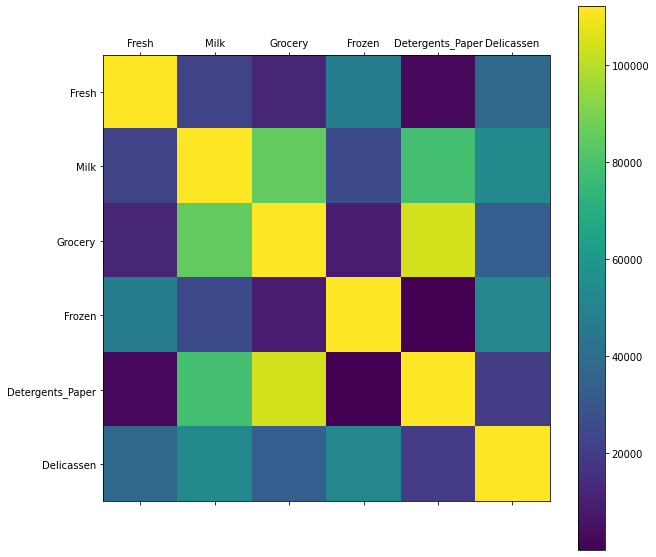

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, interpolation='nearest')
    ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);


plot_corr(data)

### Question 3
Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?

Hint: Is the data normally distributed? Where do most of the data points lie?

### Answer: 
I have plotted a correlation matrix to compare with the scatter matrix to ensure this answer is as accurate as possible.
The follow pairs of features seem to have some correlation as observed from the scatter plot showing a linear trend and the correlation plot showing a high correlation between the two features. I have ranked them in order of correlation from strongest to weakest:

* Grocery and Detergents_Paper.
* Grocery and Milk.
* Detergents_Paper and Milk (not too strong).

These features that are strongly correlated does lend credence to our initial claim that Grocery may not be necessary for identifying customers' spending habits.

Grocery has a high correlation with Detergents_Paper and Milk that corresponds to a relatively high R2 score when we regress Grocery on all other features.

The data are not normally distributed due to the presence of many outliers.
Evidently, most are skewed to the left where most of the data points lie.
This indicates how normalization is required to make the data features normally distributed as clustering algorithms require them to be normally distributed.

### Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most often appropriate to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a Box-Cox test, which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
* Assign a copy of the data to log_data after applying a logarithm scaling. Use the np.log function for this.
* Assign a copy of the sample data to log_samples after applying a logrithm scaling. Again, use np.log.

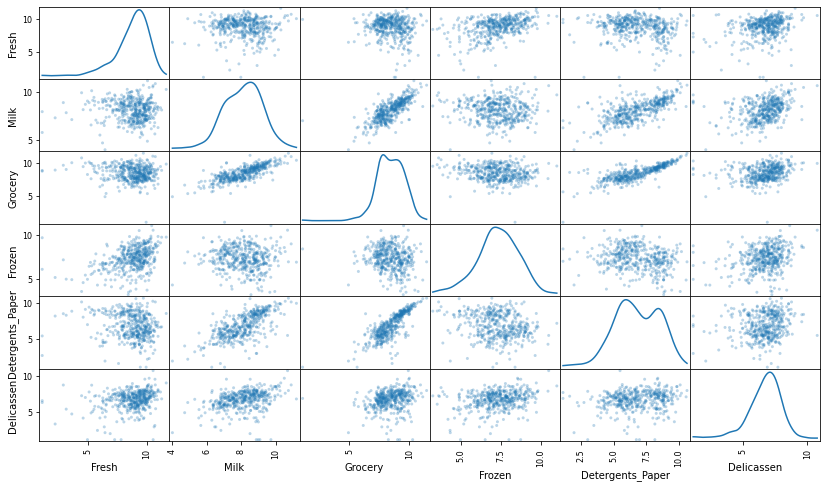

In [17]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [18]:
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
1,10.156850,8.192294,7.607381,9.240190,5.749393,7.232733
2,7.299121,9.614605,9.386308,6.495266,8.266421,8.162801


### Outliers Detection

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use Tukey's Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal. The process as follows:

* Assign the value of the 25th percentile for the given feature to Q1. Use np.percentile for this.
* Assign the value of the 75th percentile for the given feature to Q3. Again, use np.percentile.
* Assign the calculation of an outlier step for the given feature to step.
* Optionally remove data points from the dataset by adding indices to the outliers list.

In [19]:
from scipy import stats

# Keep outlier indices in a list and examine after looping thru the features
idx = []


# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3 - Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    # Gather the indexes of all the outliers
    idx += log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.tolist()

print(sorted(idx))
 
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = []

#outliers = list(unique_everseen(idx))

import collections

outliers = [item for item, count in collections.Counter(idx).items() if count > 1]


print(sorted(outliers))

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)


print(log_data.shape)
print(good_data.shape)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicassen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


[38, 57, 65, 65, 66, 66, 75, 75, 81, 86, 95, 96, 98, 109, 128, 128, 137, 142, 145, 154, 154, 154, 161, 171, 175, 183, 184, 187, 193, 203, 218, 233, 264, 285, 289, 304, 305, 325, 338, 343, 353, 355, 356, 357, 412, 420, 429, 439]
[65, 66, 75, 128, 154]
(440, 6)
(435, 6)


### Question 4
Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the outliers list to be removed, explain why. 

An outlier is an observation point that is distant from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error; the latter are sometimes excluded from the data set.

Outliers can occur by chance in any distribution, but they often indicate either measurement error or that the population has a heavy-tailed distribution. In the former case one wishes to discard them or use statistics that are robust to outliers, while in the latter case they indicate that the distribution has high skewness and that one should be very cautious in using tools or intuitions that assume a normal distribution. 

A frequent cause of outliers is a mixture of two distributions, which may be two distinct sub-populations, or may indicate 'correct trial' versus 'measurement error'; this is modeled by a mixture model.

Also as per the box plot (above) and method IQR shows there are many outliers As per IQR Find the inter quartile range, which is IQR = Q3 - Q1, where Q3 is the third quartile and Q1 is the first quartile. Then find these two numbers: a) Q1 - 1.5IQR b) Q3 + 1.5IQR The point is an outlier if < a or > b.

If any data points were added to the outliers list to be removed, explain why.

We can see that with this method 1/2 of the points are considered as outliers and I don't like to remove so many data points so I have implemented another method Z score (based on standard deviation), I have considered the data outside the 2sigma as outliers this will remove 62 outlier points from dataset.

we have to sometime careful as Outliers, being the most extreme observations, may include the sample maximum or sample minimum, or both, depending on whether they are extremely high or low. However, the sample maximum and minimum are not always outliers because they may not be unusually far from other observations.

### Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA
Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the good_data to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.
In the code block below, you will need to implement the following:

* Import sklearn.decomposition.PCA and assign the results of fitting PCA in six dimensions with good_data to pca.
* Apply a PCA transformation of the sample log-data log_samples using pca.transform, and assign the results to pca_samples.

In [20]:
def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)


 [0.44302505 0.70681723 0.82988103 0.93109011 0.97959207 1.        ]


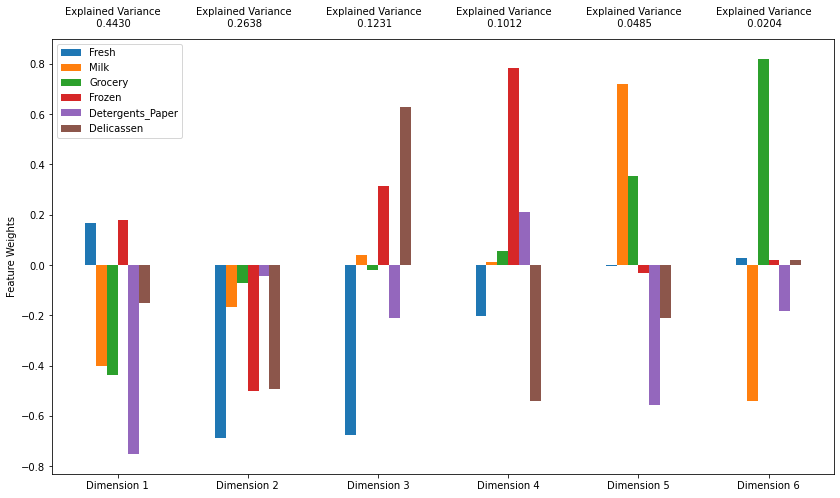

In [21]:
from sklearn.decomposition import PCA


# TODO: Apply PCA to the good data with the same number of dimensions as features

pca = PCA(n_components=6).fit(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)
#pca.fit(log_samples)

# Generate PCA results plot
pca_results = pca_results(good_data, pca)

# cumulative explaned variance
print('\n', np.cumsum(pca.explained_variance_ratio_))

In [22]:
# DataFrame of results
display(pca_results)

# DataFrame
display(type(pca_results))

# Cumulative explained variance should add to 1
display(pca_results['Explained Variance'].cumsum())

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941
Dimension 3,0.1231,-0.6774,0.0402,-0.0195,0.3150,-0.2117,0.6286
Dimension 4,0.1012,-0.2043,0.0128,0.0557,0.7854,0.2096,-0.5423
Dimension 5,0.0485,-0.0026,0.7192,0.3554,-0.0331,-0.5582,-0.2092
Dimension 6,0.0204,0.0292,-0.5402,0.8205,0.0205,-0.1824,0.0197


pandas.core.frame.DataFrame

Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64

## Question 5
How much variance in the data is explained in total by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.

Hint: A positive increase in a specific dimension corresponds with an increase of the positive-weighted features and a decrease of the negative-weighted features. The rate of increase or decrease is based on the indivdual feature weights.

## Answer:
70.68% of the variance in the data is explained by the first and second principal components.
93.11% of the variance in the data is explained by the first four principal components.

Components breakdown:

* The first principal component (PC1):
  1. An increase in PC1 is associated with large increases in "Milk", "Grocery" and "Detergents_Paper" spending.
  2. These features best represent PC1.
  3. This is in line with our initial findings where the 3 features are highly correlated.
* The second principal component (PC2):
  1. An increase in PC2 is associated with large increases in "Fresh", "Frozen" and "Delicatessen" spending.
  2. These features best represent PC2.
  3. This makes sense as PC1 represents different features. And in PC2, the features in PC1 have very small positive weights.
* The third principal component (PC3):
  1. An increase in PC3 is associated with a large increase in "Delicatessen" and a large decrease in "Fresh" spending.
  2. These features best represent PC3.
* The fourth principal component (PC4):
  1. An increase in PC4 is associated with a large increasing in "Frozen" and a large decrease in "Delicatessen" spending.
  2. These features best represent PC4.

## Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [23]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-0.9434,3.8210,-2.7013,2.8132,3.0338,0.4677
1,1.6302,-2.0843,0.2416,0.6619,0.1491,-0.4524
2,-2.7186,0.3198,1.3868,-0.7698,0.3031,-0.3414


### Dimensionality Reduction

When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the cumulative explained variance ratio is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
* Assign the results of fitting PCA in two dimensions with good_data to pca.
* Apply a PCA transformation of good_data using pca.transform, and assign the results to reduced_data.
* Apply a PCA transformation of log_samples using pca.transform, and assign the results to pca_samples.

In [24]:
pca = PCA(n_components=2)
pca.fit(log_data)

reduced_data = pca.transform(log_data)
pca_samples = pca.transform(log_samples)

reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation

Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [25]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-0.9845,3.8525
1,1.6203,-2.1223
2,-2.7336,0.2403


## Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the cumulative explained variance ratio is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:

* Assign the results of fitting PCA in two dimensions with good_data to pca.
* Apply a PCA transformation of good_data using pca.transform, and assign the reuslts to reduced_data.
* Apply a PCA transformation of the sample log-data log_samples using pca.transform, and assign the results to pca_samples.

In [26]:
pca = PCA(n_components=2).fit(good_data)

# TODO: Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

## Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [27]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))
print(reduced_data[:10])

,Dimension 1,Dimension 2
0,-0.9434,3.8210
1,1.6302,-2.0843
2,-2.7186,0.3198


   Dimension 1  Dimension 2
0    -1.757983     0.009711
1    -1.788665    -0.812251
2    -1.883353    -1.599135
3     1.155265    -1.405201
4    -0.784786    -2.394294
5    -1.085043    -0.324315
6    -1.128640     0.262863
7    -1.567236    -0.901014
8    -0.863567     0.664968
9    -2.873382    -0.677438


## Clustering
In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm?

K Means clustering* is a quick and conceptually straightforward algorithm for clustering data. It works well when the data clusters are relatively simple in shape, like Gaussian hyperspheres, but can struggle to identify clusters properly when the clusters have more complex non-linear geometries.
Gaussian Mixture Models is an generalization of K Means clustering that takes into account the covariance of the data. It os very fast, and it does not presume the data has a specific structure that may in fact not be applicable. (From http://scikit-learn.org/stable/modules/)

Now, lets imagine some unclustered data. K-means/Mixture of Gaussians tries to break them into clusters. Let's says we are aiming to break them into three clusters. K means will start with the assumption that a given data point belongs to one cluster. Choose a data point. At a given point in the algorithm, we are certain that a point belongs to a cluster 1. In the next iteration, we might revise that belief, and be certain that it belongs to the cluster 2. However, remember, in each iteration, we are absolutely certain as to which cluster the point belongs to. This is the "hard assignment".
What if we are uncertain? What if we think, well, I can't be sure, but there is 70% chance it belongs to the cluster 1, but also 10% chance its in Cluster 2, 20% chance it might be Cluster 3. That's a soft assignment. The Mixture of Gaussian model helps us to express this uncertainty. It starts with some prior belief about how certain we are about each point's cluster assignments. As it goes on, it revises those beliefs. But it incorporates the degree of uncertainty we have about our assignment.
Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?
I have manually checked both the algos in our dataset against silhouette_score and it came out K-means is performing better than GMM. K-means is an effective algo. to extract a given number of clusters from a training set and in our case it is doing better than GMM clustering.

GMM clustering is more flexible but need not to be the more accurate than K-means because you can view it as a fuzzy or soft clustering method. Soft clustering methods assign a score to a data point for each cluster. The value of the score indicates the association strength of the data point to the cluster. As opposed to hard clustering methods, soft clustering methods are flexible in that they can assign a data point to more than one cluster. When clustering with GMMs, the score is the posterior probability. For an example of soft clustering using GMM.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known a priori, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the mean silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:

* Fit a clustering algorithm to the reduced_data and assign it to clusterer.
* Predict the cluster for each data point in reduced_data using clusterer.predict and assign them to preds.
* Find the cluster centers using the algorithm's respective attribute and assign them to centers.
* Predict the cluster for each sample data point in pca_samples and assign them sample_preds.
* Import sklearn.metrics.silhouette_score and calculate the silhouette score of reduced_data against preds.
* Assign the silhouette score to score and print the result.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


7 clusters: 0.36313
6 clusters: 0.36104


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


5 clusters: 0.35221
4 clusters: 0.3339


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


3 clusters: 0.39689
2 clusters: 0.42628


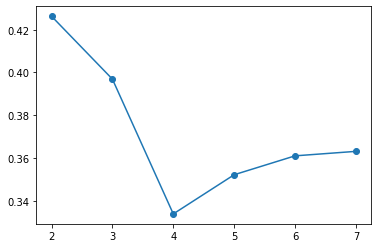

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#keep the scores for each cluster size
sil_scores = []

random_state = 7

for i in range(7,1,-1):
    clusterer = KMeans(i, random_state=random_state).fit(reduced_data)
    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    sil_scores.append(score)
    print(i, 'clusters:', score.round(5))

# plot the scores
import matplotlib.pyplot as plt
_ = plt.plot(np.arange(7,1,-1), sil_scores, '-o')

## Question 7
Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score? 

Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object lies within its cluster. 
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The silhouette score (SS) comes out to be 7 clusters: 0.35491 6 clusters: 0.36365 5 clusters: 0.35319 4 clusters: 0.33115 3 clusters: 0.36399 2 clusters: 0.44716
The best silhouette score is for 2 clusters whihc is obvious as seperating any data points with a plane is the easiest but our underline data in question is more complex than the 2 clusters and if you read carefully on the grouping (G1, G2, G3, G4, G5 and G6) are the most logical groups based on total spending profile of individual cutstomers.

## Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

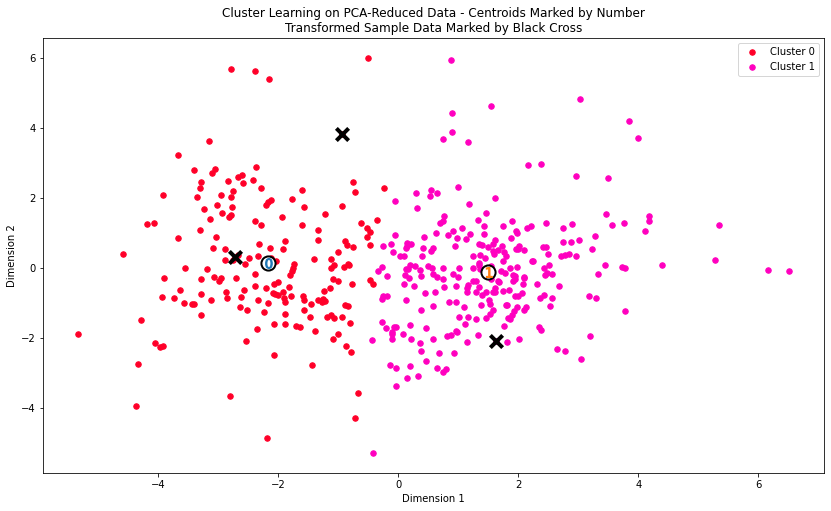

In [29]:
# Display the results of the clustering from implementation
cluster_results(reduced_data, preds, centers, pca_samples)

### Visualizing a Biplot

A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case Dimension 1 and Dimension 2). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

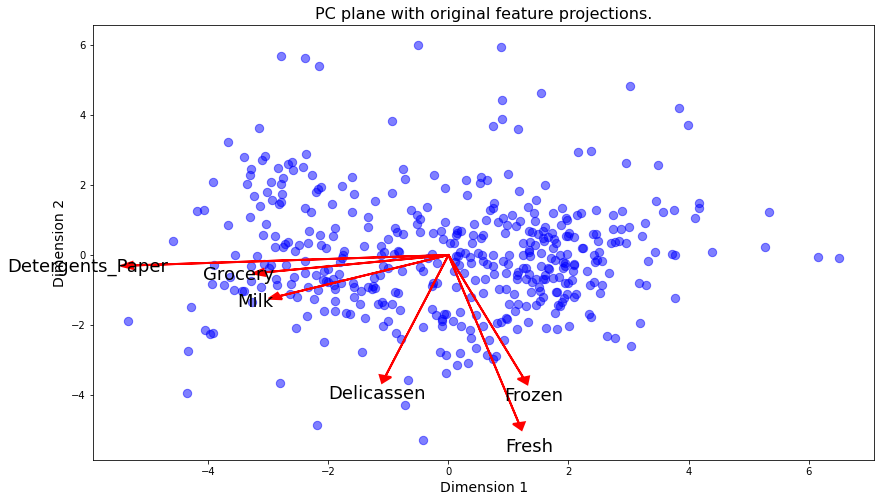

In [31]:
biplot(log_data, reduced_data, pca)

### Observations:

Frozen, Fresh and Delicassen are the features most strongly correlated with the Dimension 1.

Detergents_Paper, Grocery, and Milk are the features most strongly correlated with the Dimension 2.

### Clustering

In the code block below, you will need to implement the following:
* Fit a clustering algorithm to the reduced_data and assign it to clusterer.
* Predict the cluster for each data point in reduced_data using clusterer.predict and assign them to preds.
* Find the cluster centers using the algorithm's respective attribute and assign them to centers.
* Predict the cluster for each sample data point in pca_samples and assign them sample_preds.
* Import sklearn.metrics.silhouette_score and calculate the silhouette score of reduced_data against preds.
* Assign the silhouette score to score and print the result.

In [32]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

clusterer = GaussianMixture(n_components=2, covariance_type='full')
clusterer.fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print("Silhouette coefficient for {} clusters: {:.3f}".format(2, score))

Silhouette coefficient for 2 clusters: 0.422


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  "X does not have valid feature names, but"


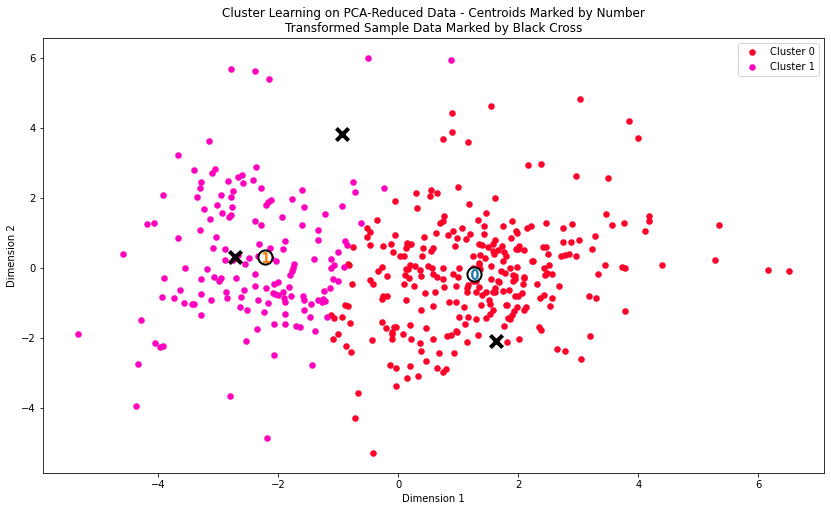

In [34]:
cluster_results(reduced_data, preds, centers, pca_samples)

### Data recovery

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to the average customer of that segment. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:

* Apply the inverse transform to centers using pca.inverse_transform and assign the new centers to log_centers.

* Apply the inverse function of np.log to log_centers using np.exp and assign the true centers to true_centers.

In [35]:
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,8939.0,2108.0,2758.0,2073.0,352.0,730.0
Segment 1,3567.0,7860.0,12249.0,873.0,4713.0,966.0


Average purchase costs for each category:
Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicassen           1524.870455
dtype: float64


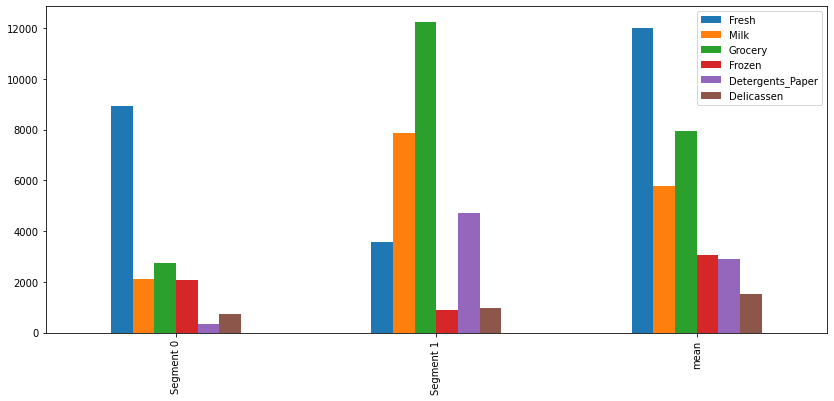

In [36]:
print('Average purchase costs for each category:')
print(data.sum() / 440)

# Visualize samples
true_centers_bar = true_centers.append(data.describe().loc['mean'])
_ = true_centers_bar.plot(kind='bar', figsize=(14,6))

Cluster 0 has a high demand on Fresh category, though it has a lower than average for every category. It should best identify as  the small fresh produce markets.

Cluster 1 has a higher than average demand on Grocery, Milk and Detergents Paper categories. It should best identify as the retailers.

In [37]:
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


My initial assumption for Sample point 0 is not consistent with it's predicted classification of Cluster 0. It has a very similar distribution of needs as Cluster 1, where your typical fresh produce market has Fresh foods as their primary product, and a small selection of Frozen foods.
My initial prediction for Sample point 1 is completely consistent with it's predicted classification of Cluster 0. It has a very similar distribution of needs as Cluster 0, where your typical cafe or restaurant needs a good supply Milk and Grocery ingredients, and a good supply of Detergents_Paper to clean & sanitize the place and provide paper napkins for their customers.
It's hard to say whether my initial prediction for Sample point 2 is consistent with it's predicted classification of Cluster 0. Your typical deli inherently needs a lot of Delicatessen foods and some need for Grocery and Fresh foods. Neither clusters put too much importance on Delicatessen foods, and while it's Grocery needs matches Cluster 0, it's Fresh foods needs better matches Cluster 1. We can see it's on the border between the two clusters in the cluster visualization (after Question 7), so we can't have much confidence in which cluster it belongs to either way.